In [1]:
from pathlib import Path
from rdkit import Chem
from iotbx.data_manager import DataManager
import numpy as np
import tqdm
import torch
import torch.nn as nn
import dgl

Using backend: pytorch


In [2]:
import sys
sys.path.append("../PhenixML/")

In [3]:
# get molecules
from pathlib import Path
mol_dir = Path("/dev/shm/cschlick/geostd_passed")
#mol_dir = Path("/dev/shm/cschlick/csd_passed/")
mol_files = [file for file in mol_dir.glob("**/*") if file.suffix == ".mol"][:10000]
print("Total MOL2 files:",len(mol_files))


Total MOL2 files: 10000


In [4]:
from phenixml.fragments.fragments import ModelContainer, Fragment
containers = [ModelContainer.from_file_name(file,removeHs=True) for file in mol_files]
container = containers[0]

RDKit WARNING: [22:57:51] WARNING: not removing hydrogen atom without neighbors
[22:57:51] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [22:57:52] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[22:57:52] Explicit valence for atom # 13 Cl, 5, is greater than permitted


In [5]:
frag_name = "fragment"
node_name = "atom"

In [6]:
from phenixml.fragments.fragmenters import BondFragmenter, FragmenterBase
from phenixml.fragments.fragmenters import AngleFragmenter
from phenixml.labelers.labelers import AngleFragLabeler

In [7]:
from phenixml.fragments.fragments import ModelContainer, Fragment
from phenixml.featurizers.atom_featurizers import RDKIT_Fingerprint
from phenixml.graphs.graph_utils import build_fragment_heterograph, build_atom_graph_from_rdkit, get_indices_from_mol
from rdkit.Chem import rdMolTransforms

# debug
from molgraph.build_graphs import build_heterograph_from_homo_mol

class MolGraph:
  def __init__(self,model_container,
               fragmenter=AngleFragmenter(),
               bond_fragmenter = BondFragmenter(),
               nonbonded_fragmenter = None,
               fragment_labeler=AngleFragLabeler(),
               atom_featurizer=RDKIT_Fingerprint(),
              frag_name = "fragment",
              node_name = "atom",
              label_ref_name = "ref"):
    
    
    
    self.model_container = model_container
    self.fragmenter = fragmenter
    self.atom_featurizer = atom_featurizer
    
    # use rdkit
    self.atom_graph = build_atom_graph_from_rdkit(model_container.rdkit_mol,atom_featurizer=atom_featurizer)
    
#     # fragment
#     connect_fragments = edge_fragmenter.fragment(model_container)
#     fragments = fragmenter.fragment(model_container)
    
#     connect_idxs = np.array([fragment.atom_selection for fragment in connect_fragments])
#     fragment_idxs = np.array([fragment.atom_selection for fragment in fragments])
    
#     self.heterograph = build_fragment_heterograph(atom_graph = self.atom_graph,
#                                                   connect_idxs=connect_idxs,
#                                                   frag_idxs=fragment_idxs,
#                                                   frag_name = frag_name,
#                                                   node_name = node_name,
#                                                   connect_name = connect_name)
    
    
    
#     labels = [fragment_labeler(fragment) for fragment in fragments]
#     labels = np.array(labels)[:,np.newaxis]
#     self.heterograph.nodes[frag_name].data[label_ref_name] = torch.tensor(labels,dtype=torch.get_default_dtype())

    rdkit_mol = container.rdkit_mol
    idxs = get_indices_from_mol(rdkit_mol)
    self.idxs = idxs
    atom_idxs = np.arange(self.atom_graph.number_of_nodes())[:,np.newaxis]
    fragments = fragmenter.fragment(self.model_container)
    fragment_idxs = np.array([fragment.atom_selection for fragment in fragments])
    #fragment_idxs = np.vstack([fragment_idxs,np.flip(fragment_idxs,axis=1)])
    bonded_fragments = bond_fragmenter.fragment(self.model_container)
    bonded_idxs = np.array([fragment.atom_selection for fragment in bonded_fragments])
    bonded_idxs = np.vstack([bonded_idxs,np.flip(bonded_idxs,axis=1)])
    if nonbonded_fragmenter:
      nonbonded_fragments = nonbonded_fragmenter.fragment(self.model_container)
      nonbonded_idxs = np.array([fragment.atom_selection for fragment in nonbonded_fragments])
      nonbonded_idxs = np.vstack([nonbonded_idxs,np.flip(nonbonded_idxs,axis=1)])
    else:
      nonbonded_idxs = None
    self.heterograph = build_fragment_heterograph(atom_graph = self.atom_graph,
                                            atom_idxs = atom_idxs,
                                            bonded_idxs=bonded_idxs,
                                            nonbonded_idxs=nonbonded_idxs,
                                            frag_idxs=fragment_idxs,
                                            frag_name = frag_name,
                                            node_name = node_name)
    
    labels = np.array([fragment_labeler(fragment) for fragment in fragments])
    #labels = np.concatenate([labels,labels])
    labels = labels[:,np.newaxis]
    self.heterograph.nodes[frag_name].data[label_ref_name] = torch.tensor(labels,dtype=torch.get_default_dtype())
    

    # conf = rdkit_mol.GetConformer()
    # angles_rad = []
    # for idx1,idx2,idx3 in idxs["n3"]:
    #   angle_rad = Chem.rdMolTransforms.GetAngleRad(conf,int(idx1),int(idx2),int(idx3))
    #   angles_rad.append(angle_rad)
    # angles_rad = np.array(angles_rad)[:,np.newaxis]
    # self.heterograph.nodes[frag_name].data["ref"] = torch.tensor(angles_rad,dtype=torch.get_default_dtype())
    
  @property
  def rdkit_mol(self):
    return self.model_container.rdkit_mol

In [8]:
molgraph = MolGraph(containers[0])

In [9]:
molgraphs = []
for container in tqdm.tqdm(containers):
  try:
    molgraph = MolGraph(container)
    # molgraph = MolGraph(container,
    #                 fragmenter=angle_fragmenter,
    #                 edge_fragmenter=bond_fragmenter,
    #                 fragment_labeler=angle_labeler,
    #                 frag_name = frag_name,
    #                 node_name = node_name,
    #                 connect_name = connect_name)
    molgraphs.append(molgraph)
  except:
    pass

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:27<00:00, 67.59it/s]


In [10]:
batch = dgl.batch([molgraph.heterograph for molgraph in molgraphs])

In [11]:
batch

Graph(num_nodes={'atom': 226000, 'fragment': 332504},
      num_edges={('atom', 'atom_as_0_in_fragment', 'fragment'): 332504, ('atom', 'atom_as_1_in_fragment', 'fragment'): 332504, ('atom', 'atom_as_2_in_fragment', 'fragment'): 332504, ('atom', 'atom_bonded_atom', 'atom'): 480276},
      metagraph=[('atom', 'fragment', 'atom_as_0_in_fragment'), ('atom', 'fragment', 'atom_as_1_in_fragment'), ('atom', 'fragment', 'atom_as_2_in_fragment'), ('atom', 'atom', 'atom_bonded_atom')])

In [12]:
# model

#mine
from phenixml.models.message_passing import MessagePassing
from phenixml.models.readout import JanossyReadout


n_units = 128
n_layers = 3
fragment_size = 3
feature_units = molgraphs[0].heterograph.nodes[node_name].data["h0"].shape[1]

config = []
for n_layer in range(n_layers):
  config+=[n_units,"relu"]
  
  
sc = lambda in_feats,out_feats: dgl.nn.pytorch.conv.sageconv.SAGEConv(in_feats,out_feats,"mean",bias=True) # dgl saveconv layer

message_passing = MessagePassing(
    feature_units=feature_units,
    layer=sc, # use SAGEConv implementation in DGL
    #layer=esp.nn.dgl_legacy.gn("SAGEConv"),
    config=config,
    atom_node_name = node_name,
    fragment_name = frag_name,
    edge_type="bonded"
) 

message_passing2 = MessagePassing(
    feature_units=feature_units,
    layer=sc, # use SAGEConv implementation in DGL
    #layer=esp.nn.dgl_legacy.gn("SAGEConv"),
    config=config,
    atom_node_name = node_name,
    fragment_name = frag_name,
    edge_type="nonbonded"
) 

n_units = 128
n_layers = 2
config = []
for n_layer in range(n_layers):
  config+=[n_units,"relu"]
  
readout = JanossyReadout(
    in_features=n_units, config=config,
    out_features={"eq":1},
    atom_node_name = node_name,
    fragment_name = frag_name,
    fragment_size = 3
)
model = nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)


# esp
# from molgraph.esp_fragments.sequential import EspSequential
# from molgraph.esp_fragments.pooling import EspJanossyPooling


# n_units = 128
# n_layers = 3
# config = []
# for n_layer in range(n_layers):
#   config+=[n_units,"relu"]
  
  
# sc = lambda in_feats,out_feats: dgl.nn.pytorch.conv.sageconv.SAGEConv(in_feats,out_feats,"mean",bias=True) # dgl saveconv layer

# message_passing = EspSequential(
#     feature_units=batch.nodes[node_name].data["h0"].shape[1],
#     layer=sc, # use SAGEConv implementation in DGL
#     #layer=esp.nn.dgl_legacy.gn("SAGEConv"),
#     config=config,
# )  

# n_units = 128
# n_layers = 2
# config = []
# for n_layer in range(n_layers):
#   config+=[n_units,"relu"]
  
# readout = EspJanossyPooling(
#     in_features=n_units, config=config,
#     out_features={              
#         #1: {"xyz": 3},
#          3: {"eq":1}
#         #3: {"eq": 1},
#         #4: {"cmplx": 2},
#         #4: {"tor": 1},
#         },
# )

# model = nn.Sequential(message_passing,readout)
# opt = torch.optim.Adam(model.parameters(),lr=1e-4)

In [13]:
model(batch)

Graph(num_nodes={'atom': 226000, 'fragment': 332504},
      num_edges={('atom', 'atom_as_0_in_fragment', 'fragment'): 332504, ('atom', 'atom_as_1_in_fragment', 'fragment'): 332504, ('atom', 'atom_as_2_in_fragment', 'fragment'): 332504, ('atom', 'atom_bonded_atom', 'atom'): 480276},
      metagraph=[('atom', 'fragment', 'atom_as_0_in_fragment'), ('atom', 'fragment', 'atom_as_1_in_fragment'), ('atom', 'fragment', 'atom_as_2_in_fragment'), ('atom', 'atom', 'atom_bonded_atom')])

In [14]:
def loss_fn(g):
  # a heterograph
  metric = torch.nn.MSELoss()
  loss = metric(g.nodes[frag_name].data["eq"],g.nodes[frag_name].data["ref"])
  return loss

In [15]:
batch = batch.to("cuda:1")
model = model.to("cuda:1")


In [16]:
epoch_losses = []
n_epoch=2000
avg_loss = "inf"

for epoch in tqdm.tqdm(range(n_epoch)):
    
  g = model(batch)
  loss = loss_fn(g)
  opt.zero_grad()
  loss.backward()
  opt.step()
  
  epoch_losses.append(loss.item())
  


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:58<00:00,  5.57it/s]


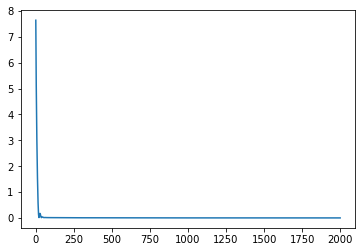

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def to_np(tensor):
  return tensor.detach().cpu().numpy()

plt.plot(epoch_losses)
#plt.plot(loss_history_n3[10:])

In [18]:
epoch_losses[-1]

0.0017638257704675198

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



def plot_geom_eval(a,b,mode="bond",s=0.01):
  

    
  fig, axs = plt.subplots(1,2,figsize=(16,5))
  axs = axs.flatten()
  
  # scatter plot
  ax = axs[0]
  ax.scatter(a,b,s=s)
  #sns.kdeplot(a,b,fill=True)
  if mode == "bond":
    ax.set_xlim(1,1.8)
    ax.set_ylim(1,1.8)
    units = "(ang.)"
  elif mode == "angle":
    ax.set_xlim(50,140)
    ax.set_ylim(50,140)
    units = "(deg.)"
  ax.plot([0,200],[0,200],color="black")
  ax.set_xlabel("Reference "+units,fontsize=14)
  ax.set_ylabel("Predicted "+units,fontsize=14)
  
  
  # histogram
  ax = axs[1]
  sns.histplot(a-b,ax=ax,kde=True,stat="density")
  if mode == "bond":
    ax.set_xlim(-3,3)
  elif mode == "angle":
    ax.set_xlim(-20,20)
  ax.set_xlabel("Error (reference-predicted) "+units,fontsize=14)
  ax.set_ylabel("Density estimate",fontsize=14)
  mae = np.abs(a-b).mean()
  ax.set_title("MAE:"+str(mae))


In [2]:
a,b = g.nodes[frag_name].data["ref"], g.nodes[frag_name].data["eq"],
a,b = to_np(a).flatten(),to_np(b).flatten()
a,b = np.degrees(a), np.degrees(b)
#a,b = to_np(a).flatten(),to_np(b).flatten()

NameError: name 'g' is not defined

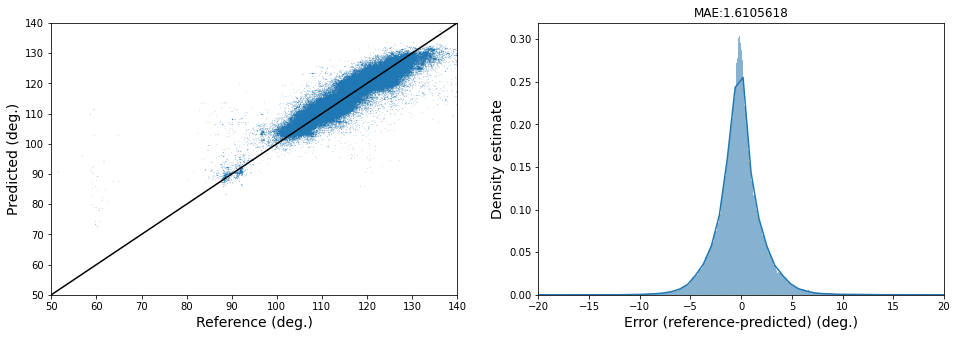

In [21]:
plot_geom_eval(a,b,s=0.005,mode="angle")

In [22]:
g.edge_type_subgraph?

Signature: g.edge_type_subgraph(etypes)
Docstring: Alias of :func:`dgl.edge_type_subgraph`.
Source:   
def edge_type_subgraph(graph, etypes):
    """Return the subgraph induced on given edge types.

    An edge-type-induced subgraph contains all the edges of the given subset of
    the edge types of a graph. It also contains all nodes of a particular type
    if some nodes of the type are incident to these edges.
    In addition to extracting the subgraph, DGL also copies the features of the
    extracted nodes and edges to the resulting graph.
    The copy is *lazy* and incurs data movement only when needed.

    Parameters
    ----------
    graph : DGLGraph
        The graph to extract subgraphs from.
    etypes : list[str] or list[(str, str, str)]
        The type names of the edges in the subgraph. The allowed type name
        formats are:

        * ``(str, str, str)`` for source node type, edge type and destination node type.
        * or one ``str`` for the edge type name  if 